### 1 Suppose the Fama-French 3-factor model works perfectly for pricing. Then the three Fama-French factors have the three highest Sharpe ratios of all assets.

False. It is not necessary for the three Fama-French factors to have the highest Sharpe Ratio as the model also depends on the cross-correlations among the factors.

### 2 The Fama-French 5-Factor model indicates that, all else equal, a stock with higher investment beta has higher expected returns.

True. The Fama-French 5-Factor model indicates that, all else equal, a stock with higher investment beta has higher expected returns. This is the CMA factor.

### 3 Suppose you show DFA that Size and Value have had Sharpe Ratios near 0 since the end of the case. Do you think they would give up on Size and Value factor strategies? Why?

No, since Value and Size still provide diversification benefits.

### 4 Suppose a stock is uncorrelated to each asset and to each Fama-French factor. Suppose this stock has a relatively high book-to-market ratio. What would the Fama-French 3-factor model predict about the mean return of this stock?

The FF3 model would predict a higher return for this stock as per the Value factor.

### 5 In constructing the momentum factor, how do we ensure that the factor does not take too much idiosyncratic risk? How do we ensure it does not have too much turnover?

More Idiosyncratic risk is avoided by using more deciles as in increase the number of individual assets or stocks in the portfolio.
Less turnover is achieved by using a longer lookback period.

### 6 Is a long-only momentum fund an attractive investment strategy? Be specific.

Undless mandated by regulatory and liquidity constraints, a long-only momentum fund is not an attractive investment strategy as it is not diversified enough. It is also not a good strategy as it is not a good risk-adjusted strategy. We see this in the case of AQR as they have a long-only momentum fund which would perform better if it was a long-short fund.

### 7 Suppose the CAPM is true, and we test n assets. For these n assets, what do we know about their...

- time-series r-squared metrics?
  - R-squared is close to 1 for all assets.
- Treynor Ratios?
  - Treynor Ratio is equal to mean excess return.
- Information Ratios?
  - Equal to 0.

### 8 Which of the following do you think Barnstable should be confident about, and which do you think they should reconsider. . .

Over 100 years,
- The average Market return will outperform the average risk-free rate.
  - Need not reconsider. We see and inverted curve.
- The 100-year Market Sharpe Ratio will outperform the 1-year Market Sharpe Ratio.
  - Reconsider
- The volatility of the 100-year cumulative Market return is smaller than volatility of the 1-year cumulative Market return.
  - Need not reconsider. We see an inverted U-shaped relationship between volatility and time horizon.

# 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings
from scipy.stats import norm
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 5)

In [3]:
factors = pd.read_excel('midterm_2_data_pricing.xlsx',1, index_col=0)
assets = pd.read_excel('midterm_2_data_pricing.xlsx',2, index_col=0)
assets.head(2)

,NG1,KC1,CC1,LB1,CT1,SB1,LC1,W1,S1,C1,GC1,SI1,HG1,PA1
Date,,,,,,,,,,,,,,
2000-01-31,0.13888,-0.12165,-0.05428,-0.01098,0.13622,-0.11848,0.02044,0.02709,0.09606,0.07169,-0.02620,-0.02738,-0.01407,0.07493
2000-02-29,0.03289,-0.10511,-0.05713,-0.05162,-0.02608,-0.14637,-0.01000,-0.04040,-0.01759,-0.02703,0.03454,-0.04951,-0.07184,0.46465


# 2.1

In [4]:
y = assets['NG1']
#del df['SPY US Equity']
x = sm.add_constant(factors)

reg = sm.OLS(y,x).fit()
reg.params

const    0.00995
MKT     -0.03769
CL1      0.25016
dtype: float64

# 2.2

In [5]:
def ts_test(df, factor_df, factors, constant = True,annualization=12):
    res = pd.DataFrame(data = None, index = df.columns, columns = ['alpha','f_1','f_2', 'r_2', 'treynor', 'info'])
    
    for port in df.columns:
        y = df[port]
        if constant:
            X = sm.add_constant(factor_df[factors])
        else:
            X = factor_df[factors]
        model = sm.OLS(y, X).fit()
        
        if constant:
            beta = model.params[1:]
            alpha = model.params[0] * annualization
            information_ratio = model.params[0] * np.sqrt(annualization) / model.resid.std()
        else:
            beta = model.params
    
        treynor = df[port].mean() * annualization / beta[0]
        tracking_error = model.resid.std() * np.sqrt(annualization)
        if constant:
            res.loc[port] = [alpha, model.params[1], model.params[2], model.rsquared, treynor, information_ratio]
        else:
            res.loc[port] = [None, model.params[0], model.params[1], model.rsquared, treynor, None]
    return res

#df is the asset portfolios which we are regressing
#factor_df is the factor data
#intercept is whether we want to include an intercept in the regression

In [6]:
#Calculate mean, standard deviation and sharpe ratio
def mean_vol_sharpe(df,ann=12):
    mean = df.mean() * ann
    volatility = df.std() * np.sqrt(ann)
    sharpe_ratio = mean/volatility
    return pd.DataFrame({'mean': mean, 'volatility': volatility, 'sharpe_ratio': sharpe_ratio})

In [7]:
df_ts = ts_test(assets, factors, ['MKT','CL1'], constant = True)
#change type to float
df_ts = df_ts.astype(float)
df_ts

,alpha,f_1,f_2,r_2,treynor,info
NG1,0.11946,-0.03769,0.25016,0.03186,-3.82052,0.22564
KC1,0.02032,0.29916,0.03211,0.02702,0.15026,0.06420
CC1,0.06321,0.11390,0.12434,0.03138,0.74433,0.19789
LB1,0.05550,0.77915,0.18740,0.16620,0.16804,0.15166
CT1,0.01302,0.52907,0.06292,0.09491,0.10820,0.04455
SB1,0.06957,0.05791,0.16275,0.03789,1.57755,0.20455
LC1,0.01627,0.10678,0.05289,0.02714,0.27690,0.08794
W1,0.05576,0.29115,-0.00255,0.02120,0.26123,0.18090
S1,0.04210,0.35327,0.03860,0.05547,0.20171,0.16343
C1,0.06094,0.25509,0.06522,0.03342,0.33735,0.20759


# 2.3

In [8]:
round(df_ts['alpha'].abs().mean(),5)
#Already annualized

0.05494

# 2.4
Report the the largest predicted premium from the model, and note which asset it is.

Ans: CL1 has the largest predicted timeseries premium of 0.10

In [9]:
factor_mean = mean_vol_sharpe(factors).iloc[:,0]
factor_mean

MKT    0.07067
CL1    0.10869
Name: mean, dtype: float64

In [10]:
def ts_premia(df_ts, factor_mean):
    #multiply factor premium row wise to each f_1 an f_2 in factor and sum
    premia = pd.DataFrame(data = None, index = df_ts.index, columns = ['TS Premia'])
    for row in df_ts.index:
        a = df_ts.loc[row, 'f_1']* factor_mean[0]
        b = df_ts.loc[row, 'f_2']* factor_mean[1]
        premia.loc[row] = a + b
        
    return premia


In [11]:
ts_premia(df_ts, factor_mean).sort_values(by='TS Premia', ascending=False)

,TS Premia
LB1,0.07543
HG1,0.06075
PA1,0.04755
CT1,0.04423
SI1,0.04142
S1,0.02916
C1,0.02512
KC1,0.02463
NG1,0.02453
SB1,0.02178


In [59]:
def cross_regression(asset_df, factors_df, factors, intercept=True, annualization=12):
    
    res = pd.DataFrame(data = None, index = factors, columns = ['cs_premia'])
    
    factors_df = factors_df.iloc[:,1:(len(factors)+1)]
    
    y = asset_df.mean() * annualization
    if intercept == True:
        X = sm.add_constant(factors_df[factors].astype(float))
    else:
        X = factors_df[factors].astype(float)
    model = sm.OLS(y, X).fit()
    if intercept:
        alpha = model.params[0]
        mae = model.resid.abs().mean()
        for i in range(len(factors)):
            res.loc[factors[i]] = model.params[i+1]
        predicted_premia = pd.DataFrame(model.resid.abs(), columns=['predicted_premia'])
    else:
        alpha = None
        mae = model.resid.abs().mean()
        for i in range(len(factors)):
            res.loc[factors[i]] = model.params[i]
        predicted_premia = pd.DataFrame(model.resid.abs(), columns=['predicted_premia'])
    
    if intercept:
        return predicted_premia, res, f'r-squared = {round(model.rsquared, 4)}', f'alpha = {round(alpha, 4)}', f'mae = {round(mae, 4)}'
    else:
        return predicted_premia,res, f'r-squared = {round(model.rsquared, 4)}', f'mae = {round(mae, 4)}'

# 3.1

In [60]:
# y = assets.mean()
# X = sm.add_constant(df_ts[['f_1','f_2']])
# model = sm.OLS(y,X).fit()
# model.rsquared
cross_regression(assets, df_ts, ['f_1','f_2'], intercept=False)

(     predicted_premia
 NG1           0.01581
 KC1           0.00721
 CC1           0.01178
 LB1           0.02164
 CT1           0.01272
 SB1           0.00219
 LC1           0.00557
 W1            0.05700
 S1            0.02633
 C1            0.03408
 GC1           0.04875
 SI1           0.02463
 HG1           0.03361
 PA1           0.02770,
     cs_premia
 f_1   0.07005
 f_2   0.52292,
 'r-squared = 0.9084',
 'mae = 0.0235')

# 3.2
Are either, neither, or both of these estimated metrics evidence against the model?

Ans: Both are evidence against the model as the R-squared is not close to 1 and the alphas are not close to 0.

# 3.3
Report the estimated factor premia. (i.e. the two cross-sectional regression slopes).
Annualize this number

In [14]:
(model.params[1:] * 12).to_frame('Estimated Factor Premia')

,Estimated Factor Premia
f_1,0.01858
f_2,0.33194


# 3.4

In [15]:
factors = factors.astype(float)
factor_1 = factors[['MKT','CL1']]
factor_1.dtypes

MKT    float64
CL1    float64
dtype: object

In [16]:
predicted = model.params[0] + (factor_1 * model.params[1:]).sum(axis=1)
MAE_cs = (assets.mean() - predicted).abs().mean() * 12

premia = pd.DataFrame(data=None, index = factor_1.index,columns=['premia'])
for row in factor_1.index:
    a = factor_1.loc[row, 'MKT']* model.params[1]
    b = factor_1.loc[row, 'CL1']* model.params[2]
    premia.loc[row] = a + b
predicted = premia.sum()[0]+model.params[0]
MAE_cs = (assets.mean() - predicted).abs().mean() * 12
MAE_cs

0.7619409144951016

In [17]:
model.resid.abs().mean() *12

0.016879605249218617

# 3.5
Report the the largest predicted premium from the model, and note which asset it is.

#### LB1 has highest

In [18]:
df_cs_cs.sort_values('Predicted', ascending=False).head(2)

NameError: name 'df_cs_cs' is not defined

# 4.1
Which is more useful in assessing the model’s fit for pricing: the r-squared of the time-series regressions, the r-squared of the cross-sectional regression, or neither?

Ans: The r-squared of the cross-sectional regression. We do not care about the r-squared of the time series regressions for pricing, while for the cross-sectional regression if r-squared is not equal to one then we know the pricing model is not completely explaining all premia that exist.

# 4.2 
We calculated the MAE from the time-series estimation and from the cross-sectional (with
intercept) estimation. Is one always bigger than the other? Why or why not?

The MAE from the time-series estimation is always bigger than the MAE from the cross-sectional estimation. This is because the time-series estimation is a regression of the asset returns on the factor returns. The cross-sectional estimation is a regression of the asset returns on the factor returns and the intercept. The intercept is the asset’s alpha. The intercept is always bigger than the factor returns.

# 4.3
If we add another factor, will the time-series MAE decrease? And how about the cross-
sectional MAE? Explain

- It is unclear whether MAE will increase or decrease in the time series test, as the intercept may increase or decrease when we add a factor.
- In the cross-sectional regression the fit must improve, as when we add a factor $R^{2}$ must increase.

# 4.4 (a)
Suppose we built a tangency portfolio using only the factors.
Compute tangency weights using just the two factors as the asset space. Does CL1
have much weight in this factor-tangency portfolio?

Ans: No CL1 holds jusy 11.8% of the weight in the factor tangency portfolio.

In [ ]:
def compute_tangency(df_tilde, diagonalize_Sigma=False):

    Sigma = df_tilde.cov()

    # N is the number of assets

    N = Sigma.shape[0]

    Sigma_adj = Sigma.copy()

    if diagonalize_Sigma:

        Sigma_adj.loc[:,:] = np.diag(np.diag(Sigma_adj))

    mu_tilde = df_tilde.mean()

    Sigma_inv = np.linalg.inv(Sigma_adj)

    weights = Sigma_inv @ mu_tilde / (np.ones(N) @ Sigma_inv @ mu_tilde)

    # For convenience, I'll wrap the solution back into a pandas.Series object.
    omega_tangency = pd.Series(weights, index=mu_tilde.index)
    
    return omega_tangency

# tangent = compute_tangency(portfolios_excess_1981)
# tangent.shape

In [ ]:
tangent = compute_tangency(factors)
tangent

MKT    0.88109
CL1    0.11891
dtype: float64

# 4.4 (b)
Conceptually, does this seem like evidence that CL1 is a useful pricing factor? Why?

Ans: Conceptually, the factors with the highest weights in the factor tangency portfolio are the most useful pricing factors. Mkt has the 88.1% weight in the factor tangency portfolio. This is evidence that Mkt is a useful pricing factor, and CL1 is not.
We also checked the correlation between CL1 and MKT to ascertain whether that was the driver of a lower tangency weight.

<AxesSubplot:>

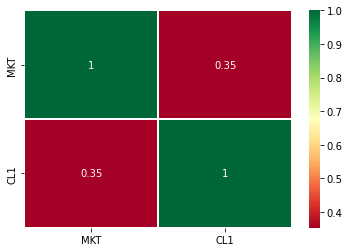

In [ ]:
corr = factors.corr()
sns.heatmap(corr, annot=True, cmap='RdYlGn', linewidths=0.2)